# Workflow for a district optimization

In this application of the ETHOS.FINE framework, a small district is modeled and optimized.

All classes which are available to the user are utilized and examples of the selection of different parameters within these classes are given.

The workflow is structures as follows:
1. Required packages are imported and the input data path is set
2. An energy system model instance is created
3. Commodity sources are added to the energy system model
4. Commodity conversion components are added to the energy system model
5. Commodity storages are added to the energy system model
6. Commodity transmission components are added to the energy system model
7. Commodity sinks are added to the energy system model
8. The energy system model is optimized
9. Selected optimization results are presented


# 1. Import required packages and set input data path

The ETHOS.FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [1]:
import fine as fn
from getData import getData
import pandas as pd

data = getData()

%load_ext autoreload
%autoreload 2
%matplotlib inline

# 2. Create an energy system model instance 

The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [2]:
locations = data["locations"]
commodityUnitDict = {"electricity": "kW_el", "methane": "kW_CH4_LHV", "heat": "kW_th"}
commodities = {"electricity", "methane", "heat"}
numberOfTimeSteps = 8760
hoursPerTimeStep = 1

The modeled locations include 6 buildings (bd1 to bd6), which are connected to different grids (grid1 to grid7), and the location of the transformer.

In [3]:
locations

{'bd1',
 'bd2',
 'bd3',
 'bd4',
 'bd5',
 'bd6',
 'grid1',
 'grid2',
 'grid3',
 'grid4',
 'grid5',
 'grid6',
 'grid7',
 'transformer'}

In [4]:
esM = fn.EnergySystemModel(
    locations=locations,
    commodities=commodities,
    numberOfTimeSteps=8760,
    commodityUnitsDict=commodityUnitDict,
    hoursPerTimeStep=1,
    costUnit="€",
    lengthUnit="m",
    verboseLogLevel=2,
)

# 3. Add commodity sources to the energy system model

### Electricity Purchase

In [5]:
esM.add(
    fn.Source(
        esM=esM,
        name="Electricity purchase",
        commodity="electricity",
        hasCapacityVariable=False,
        operationRateMax=data["El Purchase, operationRateMax"],
        commodityCost=0.298,
    )
)

### Natural Gas Purchase

In [6]:
esM.add(
    fn.Source(
        esM=esM,
        name="NaturalGas purchase",
        commodity="methane",
        hasCapacityVariable=False,
        operationRateMax=data["NG Purchase, operationRateMax"],
        commodityCost=0.065,
    )
)

### PV

In [7]:
esM.add(
    fn.Source(
        esM=esM,
        name="PV",
        commodity="electricity",
        hasCapacityVariable=True,
        hasIsBuiltBinaryVariable=True,
        operationRateMax=data["PV, operationRateMax"],
        capacityMax=data["PV, capacityMax"],
        interestRate=0.04,
        economicLifetime=20,
        investIfBuilt=1000,
        investPerCapacity=1400,
        opexIfBuilt=10,
        bigM=40,
    )
)

# 4. Add conversion components to the energy system model

### Boiler

In [8]:
esM.add(
    fn.Conversion(
        esM=esM,
        name="Boiler",
        physicalUnit="kW_th",
        commodityConversionFactors={"methane": -1.1, "heat": 1},
        hasIsBuiltBinaryVariable=True,
        hasCapacityVariable=True,
        interestRate=0.04,
        economicLifetime=20,
        investIfBuilt=2800,
        investPerCapacity=100,
        opexIfBuilt=24,
        bigM=200,
    )
)

# 5. Add commodity storages to the energy system model

### Thermal Storage 

In [9]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Thermal Storage",
        commodity="heat",
        selfDischarge=0.001,
        hasIsBuiltBinaryVariable=True,
        capacityMax=data["TS, capacityMax"],
        interestRate=0.04,
        economicLifetime=25,
        investIfBuilt=23,
        investPerCapacity=24,
        bigM=250,
    )
)

### Battery Storage

In [10]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Battery Storage",
        commodity="electricity",
        cyclicLifetime=10000,
        chargeEfficiency=0.95,
        dischargeEfficiency=0.95,
        chargeRate=0.5,
        dischargeRate=0.5,
        hasIsBuiltBinaryVariable=True,
        capacityMax=data["BS, capacityMax"],
        interestRate=0.04,
        economicLifetime=12,
        investIfBuilt=2000,
        investPerCapacity=700,
        bigM=110,
    )
)

# 6. Add commodity transmission components to the energy system model

### Cable Electricty

In [11]:
esM.add(
    fn.Transmission(
        esM=esM,
        name="E_Distribution_Grid",
        commodity="electricity",
        losses=0.00001,
        distances=data["cables, distances"],
        capacityFix=data["cables, capacityFix"],
    )
)

### Natural Gas Pipeline

In [12]:
esM.add(
    fn.Transmission(
        esM=esM,
        name="NG_Distribution_Grid",
        commodity="methane",
        distances=data["NG, distances"],
        capacityFix=data["NG, capacityFix"],
    )
)

# 7. Add commodity sinks to the energy system model

### Electricity Demand

In [13]:
esM.add(
    fn.Sink(
        esM=esM,
        name="Electricity demand",
        commodity="electricity",
        hasCapacityVariable=False,
        operationRateFix=data["Electricity demand, operationRateFix"],
    )
)

### Heat Demand

In [14]:
esM.add(
    fn.Sink(
        esM=esM,
        name="BuildingsHeat",
        commodity="heat",
        hasCapacityVariable=False,
        operationRateFix=data["Heat demand, operationRateFix"],
    )
)

# 8. Optimize energy system model

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

In [15]:
esM.aggregateTemporally(numberOfTypicalPeriods=7)

In [16]:
# esM.optimize(timeSeriesAggregation=True, optimizationSpecs='cuts=0 method=2')
esM.optimize(timeSeriesAggregation=True, solver="glpk")

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\T58C8~1.GRO\AppData\Local\Temp\tmp43bqanym.glpk.raw --wglp
 C:\Users\T58C8~1.GRO\AppData\Local\Temp\tmp3oq8qsv1.glpk.glp --cpxlp C:\Users\T58C8~1.GRO\AppData\Local\Temp\tmpkcuvn3tw.pyomo.lp
Reading problem data from 'C:\Users\T58C8~1.GRO\AppData\Local\Temp\tmpkcuvn3tw.pyomo.lp'...
C:\Users\T58C8~1.GRO\AppData\Local\Temp\tmpkcuvn3tw.pyomo.lp:201320: warning: lower bound of variable 'x8' redefined
C:\Users\T58C8~1.GRO\AppData\Local\Temp\tmpkcuvn3tw.pyomo.lp:201320: warning: upper bound of variable 'x8' redefined
32542 rows, 15260 columns, 88192 non-zeros
32 integer variables, all of which are binary
201352 lines were read
Writing problem data to 'C:\Users\T58C8~1.GRO\AppData\Local\Temp\tmp3oq8qsv1.glpk.glp'...
170387 lines were written
GLPK Integer Optimizer 5.0
32542 rows, 15260 columns, 88192 non-zeros
32 integer variables, all of which are binary
Preprocessing...
30488 rows, 12838 columns, 785

# 9. Selected results output

### Sources and Sink

In [17]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

bd1  \
Component            Property        Unit                             
BuildingsHeat        operation       [kW_th*h/a]        213008.3393   
                                     [kW_th*h]          213008.3393   
Electricity demand   operation       [kW_el*h/a]       24718.958697   
                                     [kW_el*h]         24718.958697   
Electricity purchase NPVcontribution [€]                          0   
                     TAC             [€/a]                        0   
                     commodCosts     [€/a]                      NaN   
                     operation       [kW_el*h/a]                NaN   
                                     [kW_el*h]                  NaN   
NaturalGas purchase  NPVcontribution [€]                          0   
                     TAC             [€/a]                        0   
                     commodCosts     [€/a]                      NaN   
                     operation       [kW_CH4_LHV*h/a]           NaN   
                                     [kW_CH4_LHV*h]             NaN   
PV                   NPVcontribution [€]                1926.398664   
                     TAC             [€/a]              1916.398664   
                     capacity        [kW_el]              17.888917   
                     capexCap        [€/a]              1842.816913   
                     capexIfBuilt    [€/a]                 73.58175   
                     commissioning   [kW_el]              17.888917   
                     invest          [€]               26044.483248   
                     isBuilt         [-]                        1.0   
                     operation       [kW_el*h/a]        11358.66816   
                                     [kW_el*h]          11358.66816   
                     opexIfBuilt     [€/a]                     10.0   

                                                                bd2  \
Component            Property        Unit                             
BuildingsHeat        operation       [kW_th*h/a]       211961.37319   
                                     [kW_th*h]         211961.37319   
Electricity demand   operation       [kW_el*h/a]       19409.339737   
                                     [kW_el*h]         19409.339737   
Electricity purchase NPVcontribution [€]                          0   
                     TAC             [€/a]                        0   
                     commodCosts     [€/a]                      NaN   
                     operation       [kW_el*h/a]                NaN   
                                     [kW_el*h]                  NaN   
NaturalGas purchase  NPVcontribution [€]                          0   
                     TAC             [€/a]                        0   
                     commodCosts     [€/a]                      NaN   
                     operation       [kW_CH4_LHV*h/a]           NaN   
                                     [kW_CH4_LHV*h]             NaN   
PV                   NPVcontribution [€]                        0.0   
                     TAC             [€/a]                      0.0   
                     capacity        [kW_el]                    0.0   
                     capexCap        [€/a]                      0.0   
                     capexIfBuilt    [€/a]                      0.0   
                     commissioning   [kW_el]                    0.0   
                     invest          [€]                        0.0   
                     isBuilt         [-]                        0.0   
                     operation       [kW_el*h/a]                0.0   
                                     [kW_el*h]                  0.0   
                     opexIfBuilt     [€/a]                      0.0   

                                                                 bd3  \
Component            Property        Unit                              
BuildingsHeat        operation       [kW_th*h/a]       212160.201606   
            

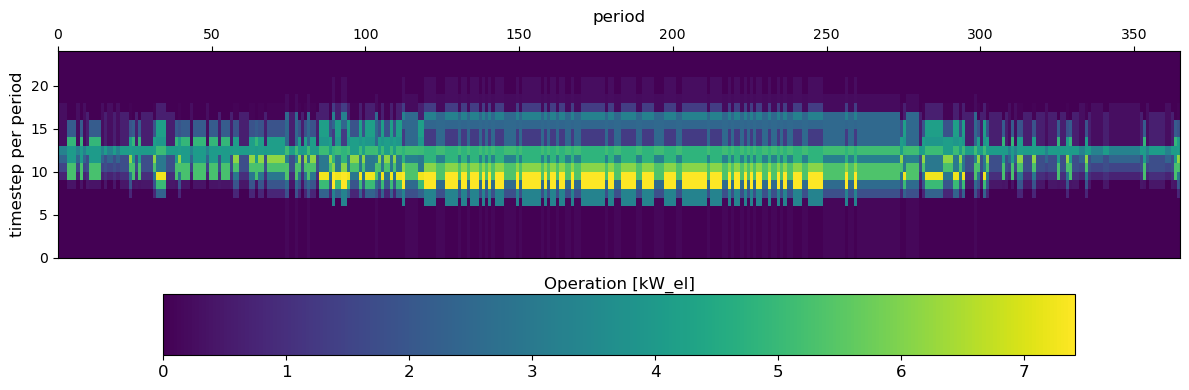

In [18]:
fig, ax = fn.plotOperationColorMap(esM, "PV", "bd1")

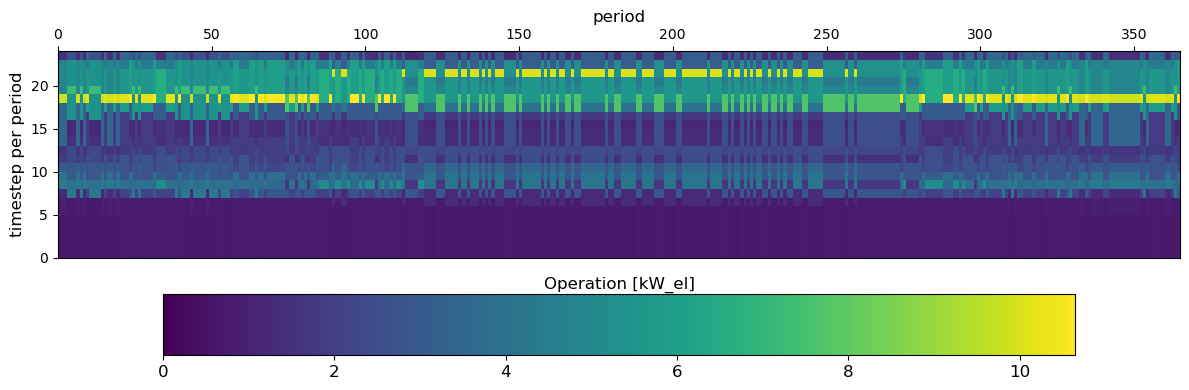

In [19]:
fig, ax = fn.plotOperationColorMap(esM, "Electricity demand", "bd1")

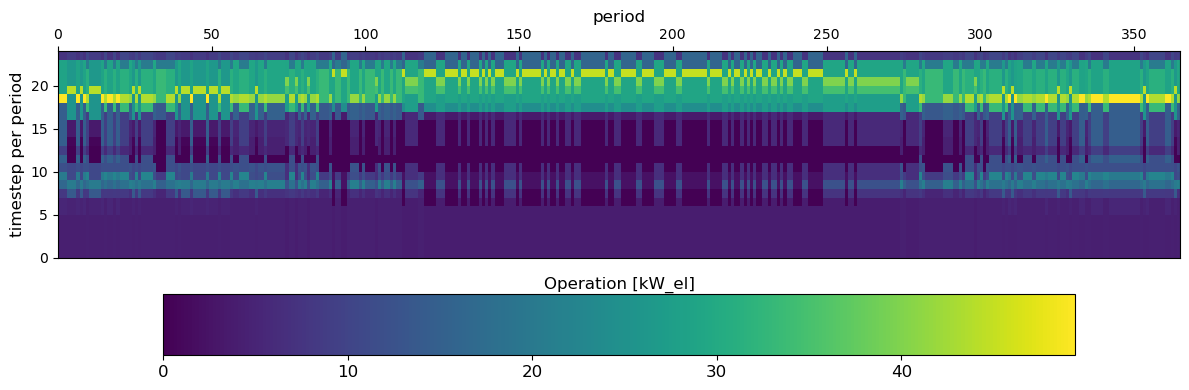

In [20]:
fig, ax = fn.plotOperationColorMap(esM, "Electricity purchase", "transformer")

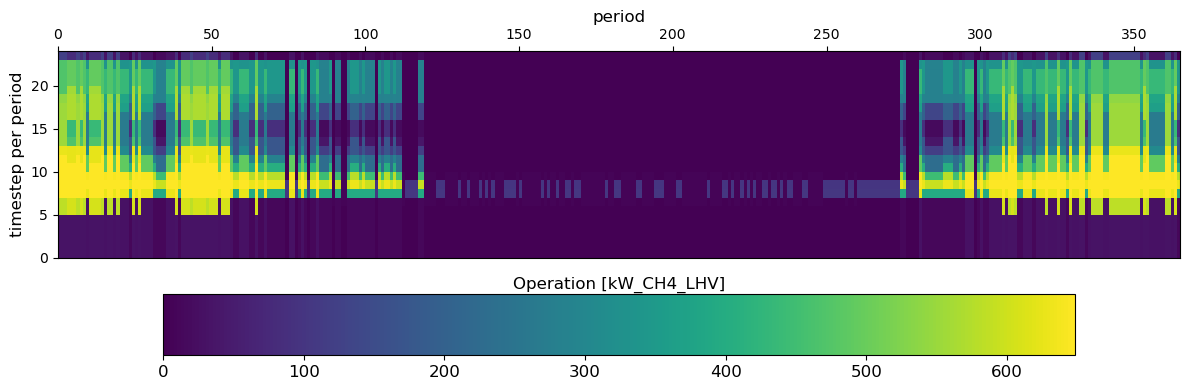

In [21]:
fig, ax = fn.plotOperationColorMap(esM, "NaturalGas purchase", "transformer")

### Conversion

In [22]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

bd1            bd2  \
Component Property        Unit                                        
Boiler    NPVcontribution [€]             883.607351     980.718203   
          TAC             [€/a]           859.607351     956.718203   
          capacity        [kW_th]          88.823444     102.021126   
          capexCap        [€/a]            653.57845     750.689302   
          capexIfBuilt    [€/a]           206.028901     206.028901   
          commissioning   [kW_th]          88.823444     102.021126   
          invest          [€]           11682.344434     13002.1126   
          isBuilt         [-]                    1.0            1.0   
          operation       [kW_th*h/a]  213048.223269  211990.635343   
                          [kW_th*h]    213048.223269  211990.635343   
          opexIfBuilt     [€/a]                 24.0           24.0   

                                                 bd3            bd4  \
Component Property        Unit                                        
Boiler    NPVcontribution [€]             937.643993    1004.157289   
          TAC             [€/a]           913.643993     980.157289   
          capacity        [kW_th]            96.1672     105.206574   
          capexCap        [€/a]           707.615092     774.128388   
          capexIfBuilt    [€/a]           206.028901     206.028901   
          commissioning   [kW_th]            96.1672     105.206574   
          invest          [€]           12416.720027    13320.65743   
          isBuilt         [-]                    1.0            1.0   
          operation       [kW_th*h/a]  212185.711381  212891.770831   
                          [kW_th*h]    212185.711381  212891.770831   
          opexIfBuilt     [€/a]                 24.0           24.0   

                                                 bd5            bd6 grid1  \
Component Property        Unit                                              
Boiler    NPVcontribution [€]             956.361348     955.452658   0.0   
          TAC             [€/a]           932.361348     931.452658   0.0   
          capacity        [kW_th]           98.71095      98.587456   0.0   
          capexCap        [€/a]           726.332447     725.423757   0.0   
          capexIfBuilt    [€/a]           206.028901     206.028901   0.0   
          commissioning   [kW_th]           98.71095      98.587456   0.0   
          invest          [€]           12671.094992   12658.745602   0.0   
          isBuilt         [-]                    1.0            1.0   0.0   
          operation       [kW_th*h/a]  213017.011012  213383.858478   0.0   
                          [kW_th*h]    213017.011012  213383.858478   0.0   
          opexIfBuilt     [€/a]                 24.0           24.0   0.0   

                                      grid2 grid3 grid4 grid5 grid6 grid7  \
Component Property        Unit                                              
Boiler    NPVcontribution [€]           0.0   0.0   0.0   0.0   0.0   0.0   
          TAC             [€/a]         0.0   0.0   0.0   0.0   0.0   0.0   
          capacity        [kW_th]       0.0   0.0   0.0   0.0   0.0   0.0   
          capexCap        [€/a]         0.0   0.0   0.0   0.0   0.0   0.0   
          capexIfBuilt    [€/a]         0.0   0.0   0.0   0.0   0.0   0.0   
          commissioning   [kW_th]       0.0   0.0   0.0   0.0   0.0   0.0   
          invest          [€]           0.0   0.0   0.0   0.0   0.0   0.0   
          isBuilt         [-]           0.0   0.0   0.0   0.0   0.0   0.0   
          operation       [kW_th*h/a]   0.0   0.0   0.0   0.0   0.0   0.0   
                          [kW_th*h]     0.0   0.0   0.0   0.0   0.0   0.0   
          opexIfBuilt     [€/a]         0.0   0.0   0.0   0.0   0.0   0.0   

                                      transformer  
Component Property        Unit                     
Boiler    NPVcontribution [€]                 0.0  
          TAC             [€/a]          

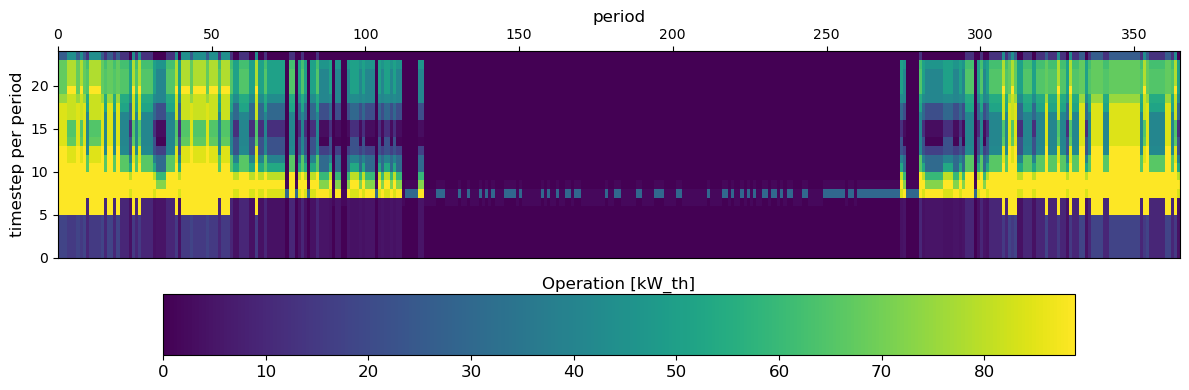

In [23]:
fig, ax = fn.plotOperationColorMap(esM, "Boiler", "bd1")

### Storage

In [24]:
esM.getOptimizationSummary("StorageModel", outputLevel=2)

bd1           bd2  \
Component       Property           Unit                                      
Battery Storage operationCharge    [kW_el*h/a]          -0.0           0.0   
                                   [kW_el*h]            -0.0           0.0   
                operationDischarge [kW_el*h/a]          -0.0           0.0   
                                   [kW_el*h]            -0.0           0.0   
Thermal Storage NPVcontribution    [€]            244.728977    223.545122   
                TAC                [€/a]          244.728977    223.545122   
                capacity           [kW_th*h]      158.340652    144.551657   
                capexCap           [€/a]          243.256702    222.072847   
                capexIfBuilt       [€/a]            1.472275      1.472275   
                commissioning      [kW_th*h]      158.340652    144.551657   
                invest             [€]           3823.175639   3492.239765   
                isBuilt            [-]                   1.0           1.0   
                operationCharge    [kW_th*h/a]  23892.887954  15657.545754   
                                   [kW_th*h]    23892.887954  15657.545754   
                operationDischarge [kW_th*h/a]  23853.003985  15628.283602   
                                   [kW_th*h]    23853.003985  15628.283602   

                                                         bd3           bd4  \
Component       Property           Unit                                      
Battery Storage operationCharge    [kW_el*h/a]           0.0           0.0   
                                   [kW_el*h]             0.0           0.0   
                operationDischarge [kW_el*h/a]           0.0           0.0   
                                   [kW_el*h]             0.0           0.0   
Thermal Storage NPVcontribution    [€]             211.68068    214.875936   
                TAC                [€/a]           211.68068    214.875936   
                capacity           [kW_th*h]      136.828854    138.908711   
                capexCap           [€/a]          210.208405    213.403661   
                capexIfBuilt       [€/a]            1.472275      1.472275   
                commissioning      [kW_th*h]      136.828854    138.908711   
                invest             [€]           3306.892507   3356.809053   
                isBuilt            [-]                   1.0           1.0   
                operationCharge    [kW_th*h/a]  19326.481737   14554.58571   
                                   [kW_th*h]    19326.481737   14554.58571   
                operationDischarge [kW_th*h/a]  19300.971962  14528.283984   
                                   [kW_th*h]    19300.971962  14528.283984   

                                                         bd5           bd6  \
Component       Property           Unit                                      
Battery Storage operationCharge    [kW_el*h/a]           0.0           0.0   
                                   [kW_el*h]             0.0           0.0   
                operationDischarge [kW_el*h/a]           0.0           0.0   
                                   [kW_el*h]             0.0           0.0   
Thermal Storage NPVcontribution    [€]            210.820358    210.313178   
                TAC                [€/a]          210.820358    210.313178   
                capacity           [kW_th*h]      136.268854     135.93872   
                capexCap           [€/a]          209.348083    208.840902   
                capexIfBuilt       [€/a]            1.472275      1.472275   
                commissioning      [kW_th*h]      136.268854     135.93872   
                invest             [€]           3293.452493   3285.529273   
                isBuilt            [-]                   1.0           1.0   
                operationCharge    [kW_th*h/a]  19826.532299  26109.918425   
                                   [kW_th*h]    19826.532299  26109.918425   

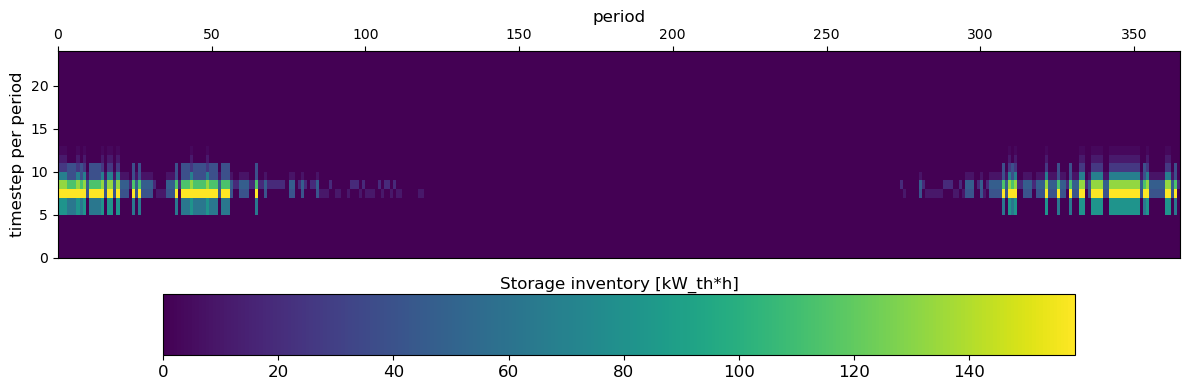

In [25]:
fig, ax = fn.plotOperationColorMap(
    esM, "Thermal Storage", "bd1", variableName="stateOfChargeOperationVariablesOptimum"
)

### Transmission

In [26]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2)

bd1  bd2  bd3  \
Component            Property  Unit           LocationIn                   
E_Distribution_Grid  capacity  [kW_el]        bd1          NaN  NaN  NaN   
                                              bd2          NaN  NaN  NaN   
                                              bd3          NaN  NaN  NaN   
                                              bd4          NaN  NaN  NaN   
                                              bd5          NaN  NaN  NaN   
...                                                        ...  ...  ...   
NG_Distribution_Grid operation [kW_CH4_LHV*h] grid4        NaN  NaN  NaN   
                                              grid5        NaN  NaN  NaN   
                                              grid6        NaN  NaN  NaN   
                                              grid7        NaN  NaN  NaN   
                                              transformer  NaN  NaN  NaN   

                                                                     bd4  \
Component            Property  Unit           LocationIn                   
E_Distribution_Grid  capacity  [kW_el]        bd1                    NaN   
                                              bd2                    NaN   
                                              bd3                    NaN   
                                              bd4                    NaN   
                                              bd5                    NaN   
...                                                                  ...   
NG_Distribution_Grid operation [kW_CH4_LHV*h] grid4                  NaN   
                                              grid5        234180.947914   
                                              grid6                  NaN   
                                              grid7                  NaN   
                                              transformer            NaN   

                                                                     bd5  \
Component            Property  Unit           LocationIn                   
E_Distribution_Grid  capacity  [kW_el]        bd1                    NaN   
                                              bd2                    NaN   
                                              bd3                    NaN   
                                              bd4                    NaN   
                                              bd5                    NaN   
...                                                                  ...   
NG_Distribution_Grid operation [kW_CH4_LHV*h] grid4                  NaN   
                                              grid5                  NaN   
                                              grid6        234318.712113   
                                              grid7                  NaN   
                                              transformer            NaN   

                                                                     bd6  \
Component            Property  Unit           LocationIn                   
E_Distribution_Grid  capacity  [kW_el]        bd1                    NaN   
                                              bd2                    NaN   
                                              bd3                    NaN   
                                              bd4                    NaN   
                                              bd5                    NaN   
...                                                                  ...   
NG_Distribution_Grid operation [kW_CH4_LHV*h] grid4                  NaN   
                                              grid5                  NaN   
                                              grid6                  NaN   
                                              grid7        234722.244326   
                                              transformer            NaN   

                                                                    grid1  \
Component            Prope